In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# LATTICE

In [2]:
#defining triangular lattice
a=1
a_1=a*np.array([1,0,0])
a_2=a*np.array([1/2,np.sqrt(3)/2,0])
zhat=np.array([0,0,1])

Vol_real=np.dot(np.cross(a_1,a_2),zhat)
b_1=np.cross(a_2,zhat)*(2*np.pi)/Vol_real
b_2=np.cross(zhat,a_1)*(2*np.pi)/Vol_real
Vol_rec=np.dot(np.cross(b_1,b_2),zhat)
#print(np.dot(a_2,b_2),np.dot(a_1,b_1))

Np=80
n1=np.arange(-Np,Np+1)
n2=np.arange(-Np,Np+1)

a_1=a_1[0:2]
a_2=a_2[0:2]
b_1=b_1[0:2]
b_2=b_2[0:2]

# BRILLOUIN ZONE SAMPLING

In [3]:
#getting the first brilloin zone from the Voronoi decomp of the recipprocal lattice
#input: reciprocal lattice vectors
#output: Points that delimit the FBZ - 
#high symmetry points (for now just the triangular lattice will be implemented)
from scipy.spatial import Voronoi, voronoi_plot_2d
def FBZ_points(b_1,b_2):
    #creating reciprocal lattice
    Np=4
    n1=np.arange(-Np,Np+1)
    n2=np.arange(-Np,Np+1)
    Recip_lat=[]
    for i in n1:
        for j in n2:
            point=b_1*i+b_2*j
            Recip_lat.append(point)
    
    #getting the nearest neighbours to the gamma point
    Recip_lat_arr=np.array(Recip_lat)
    dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=10)
    sorted_dist=sort(list(set(dist)) )
    points=Recip_lat_arr[np.where(dist<sorted_dist[2])[0]]
    
    #getting the voronoi decomposition of the gamma point and the nearest neighbours
    vor = Voronoi(points)
    Vertices=(vor.vertices)
    
    #ordering the points counterclockwise in the -pi,pi range
    angles_list=list(np.arctan2(Vertices[:,1],Vertices[:,0]))
    Vertices_list=list(Vertices)
    
    #joint sorting the two lists for angles and vertices for convenience later. 
    # the linear plot routine requires the points to be in order
    # atan2 takes into acount quadrant to get the sign of the angle 
    angles_list, Vertices_list = (list(t) for t in zip(*sorted(zip(angles_list, Vertices_list))))
    
    ##getting the M points as the average of consecutive K- Kp points
    Edges_list=[]
    for i in range(len(Vertices_list)):
        Edges_list.append([(Vertices_list[i][0]+Vertices_list[i-1][0])/2,(Vertices_list[i][1]+Vertices_list[i-1][1])/2])
    
    Gamma=[0,0]
    K=Vertices_list[0::2]
    Kp=Vertices_list[1::2]
    M=Edges_list[0::2]
    Mp=Edges_list[1::2]
    
    return Vertices_list, Gamma, K, Kp, M, Mp

In [4]:
Vertices_list, Gamma, K, Kp, M, Mp=FBZ_points(b_1,b_2)

In [5]:
#creating reciprocal lattice preparing for k-point integration
Recip_lat=[]
for i in n1:
    for j in n2:
        point=b_1*i+b_2*j
        Recip_lat.append(point)

In [6]:
#########
#####CREATING SAMPLES FOR INTEGRATION

#generating k points
kx=np.linspace(-5*np.pi/a,5*np.pi/a,100)
ky=np.linspace(-5*np.pi/a,5*np.pi/a,100)

#square sampling
#kxx,kyy=np.meshgrid(kx,ky)

#Shrinking the reciprocal lattice
scale_fac=0.00831
Recip_lat_arr=scale_fac*np.array(Recip_lat)
kxx=Recip_lat_arr[:,0]
kyy=Recip_lat_arr[:,1]

phi=2*np.pi/6 #rotation angle 

#rotating and cleaving if absolute value of rotated point's y coordinate exceeds top boundary of 1BZ
kxx_rot=np.cos(phi)*kxx-np.sin(phi)*kyy
kyy_rot=np.sin(phi)*kxx+np.cos(phi)*kyy

kxx2=kxx[np.where(np.abs(kyy_rot)<K[2][1])]
kyy2=kyy[np.where(np.abs(kyy_rot)<K[2][1])]

#rotating and cleaving if absolute value of rotated point's y coordinate exceeds top boundary of 1BZ
kxx_rot2=np.cos(-phi)*kxx2-np.sin(-phi)*kyy2
kyy_rot2=np.sin(-phi)*kxx2+np.cos(-phi)*kyy2

kxx3=kxx2[np.where(np.abs(kyy_rot2)<K[2][1])]
kyy3=kyy2[np.where(np.abs(kyy_rot2)<K[2][1])]

#cleaving if absolute value of point's y coordinate exceeds top boundary of 1BZ
KX=kxx3[np.where(np.abs(kyy3)<K[2][1])]
KY=kyy3[np.where(np.abs(kyy3)<K[2][1])]


14521 14400


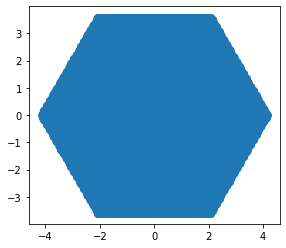

In [7]:
print((np.size(KX)),120 * 120) #number of points in the bz
#structure factor for random values of temperature and lambda
scatter(KX,KY)
plt.gca().set_aspect('equal', adjustable='box')

# STATIC STRUCTURE FACTOR

In [8]:
#defining the parameter gamma in the static structure factor
def gamma(kx,ky):
    
    a_1=a*np.array([1,0])
    a_2=a*np.array([1/2,np.sqrt(3)/2])
    
    #creating lattice
    Np=4
    n1=np.arange(-Np,Np+1)
    n2=np.arange(-Np,Np+1)
    Recip_lat=[]
    for i in n1:
        for j in n2:
            point=a_1*i+a_2*j
            Recip_lat.append(point)
    
    #getting the nearest neighbours to the gamma point
    Recip_lat_arr=np.array(Recip_lat)
    dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=8)
    sorted_dist=sort(list(set(dist)) )
    nns=Recip_lat_arr[np.where( (dist<sorted_dist[2]) *( dist>0 ))[0]]
    e=0
    for nn in nns:
        e=e+exp(1j*(nn[0]*kx+nn[1]*ky))
    
    return np.real(e)

def gamma2(kx,ky):
    return 2*np.cos(kx)+4*np.cos(kx/2)*np.cos(np.sqrt(3)*ky/2)


In [9]:

def Sf(kx,ky,lam,T):
    return 3/(lam+(1/T)*gamma2(kx,ky))
def f(lam,T,KX,KY):
    curlyN=np.size(KX)
    return np.sum(Sf(KX,KY,lam,T))/curlyN -1

In [10]:
def bisection(f,a,b,N,T,KX,KY):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> bisection(f,1,2,25)
    1.618033990263939
    >>> f = lambda x: (2*x - 1)*(x - 3)
    >>> bisection(f,0,1,10)
    0.5
    '''
    if f(a,T,KX,KY)*f(b,T,KX,KY) >= 0:
        print("Bisection method fails.")
        return None
    a_n = a
    b_n = b
    for n in range(1,N+1):
        m_n = (a_n + b_n)/2
        f_m_n = f(m_n,T,KX,KY)
        if f(a_n,T,KX,KY)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n,T,KX,KY)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
    return (a_n + b_n)/2

In [19]:
Nlam=10000
T=10
""" BS method for finding the value of lambda"""
"""
curlyN=np.size(KX)
lambds=np.linspace(3/T,20 ,Nlam)
integs=[]
for i in range(Nlam):
    integral=3*np.sum(Sf(KX,KY,lambds[i],T))/curlyN
    integs.append(integral)
    
    
ind_sol=np.argmin(np.abs(np.array(integs)-1))
print(lambds[ind_sol],integs[ind_sol])
"""

ll=bisection(f,3/T,20,50,T,KX,KY)
print(ll,f(ll,T,KX,KY)+1)

3.019417939595229 0.9999999999999997


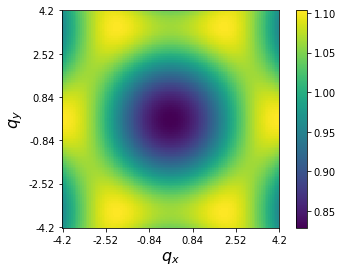

In [20]:
limits_X=4.2
limits_Y=4.2
N_X=120
N_Y=120

kx=np.linspace(-limits_X,limits_X,N_X)
ky=np.linspace(-limits_Y,limits_Y,N_Y)

kxx, kyy =meshgrid(kx,ky)
imshow(Sf(kxx,kyy,ll,T), origin='lower')


ticks_X=5
ticks_Y=5
Npl_X=np.arange(0,N_X+1,int(N_X/ticks_X))
Npl_Y=np.arange(0,N_Y+1,int(N_Y/ticks_Y))
xl=np.round(np.linspace(-limits_X,limits_X,ticks_X+1),3)
yl=np.round(np.linspace(-limits_Y,limits_Y,ticks_Y+1),3)

plt.xticks(Npl_X,xl)
plt.yticks(Npl_Y,yl)
plt.xlabel(r"$q_x$",size=16)
plt.ylabel(r"$q_y$",size=16)

colorbar()

# GENERATING TEMPERATURE AND LAMBDA ARRAYS

In [21]:
NTS=50
Ts=np.linspace(0.1,10,NTS)
lambdsol=[]
intsol=[]
for i in range(NTS):
    ll=bisection(f,3/Ts[i],40,170,Ts[i],KX,KY)
    lambdsol.append(ll)
    intsol.append(f(ll,Ts[i],KX,KY))

Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.
Found exact solution.


# LANGEVIN DYNAMIC STRUCTURE FACTOR

In [122]:
#temperature dependent fit parameters for the langevin dynamics
alphl=[0.0054342689, 0.00645511652936,0.0085441664872,0.008896935]
def alphfunc(T):
    return np.piecewise(T, [T <= 0.5, (T <= 1.0) & (T>0.5), (T <= 10.0) & (T>1.0), T>10.0], alphl)

T=10.0
ll=bisection(f,3/T,40,170,T,KX,KY)
alph=alphfunc(T)    
#dynamic structure fac
def Sfw(kx,ky,lam,T,ome, alph):
    fq=(gamma(kx,ky)**2)/T +gamma(kx,ky)*(lam-6/T)- 6*lam
    fq=alph*fq
    return -2*Sf(kx,ky,lam,T)*(fq/(ome**2+fq**2))

Found exact solution.


In [123]:
#linear parametrization accross different points in the BZ
def linpam(Kps,Npoints_q):
    Npoints=len(Kps)
    t=np.linspace(0, 1, Npoints_q)
    linparam=np.zeros([Npoints_q*(Npoints-1),2])
    for i in range(Npoints-1):
        linparam[i*Npoints_q:(i+1)*Npoints_q,0]=Kps[i][0]*(1-t)+t*Kps[i+1][0]
        linparam[i*Npoints_q:(i+1)*Npoints_q,1]=Kps[i][1]*(1-t)+t*Kps[i+1][1]
        
    return linparam

"\nL=[]\nL=L+[K[1]]+[Gamma]+[M[2]]\nNt=1000\nkpath2=linpam(L,Nt)\nscatter(kpath2[:,0],kpath2[:,1],s=3, c='g')\n"

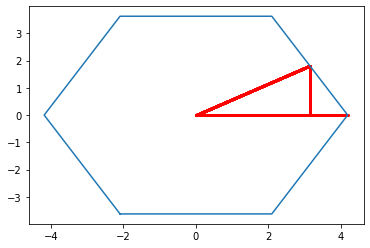

In [124]:
VV=Vertices_list+[Vertices_list[0]]
plot(linpam(VV,10)[:,0],linpam(VV,10)[:,1])
L=[]
L=L+[K[1]]+[Gamma]+[Mp[1]]+[[np.pi,0]]
Nt=1000
kpath=linpam(L,Nt)
scatter(kpath[:,0],kpath[:,1],s=3, c='r')

"""
L=[]
L=L+[K[1]]+[Gamma]+[M[2]]
Nt=1000
kpath2=linpam(L,Nt)
scatter(kpath2[:,0],kpath2[:,1],s=3, c='g')
"""

In [125]:
Nomegs=2000
omegas=np.linspace(0.0001,1 ,Nomegs)
t=np.arange(0,len(kpath),1)
t_m,omegas_m=meshgrid(t,omegas)

SSSfw=Sfw(kpath[t_m,0],kpath[t_m,1],ll,T,omegas_m, alph)

Text(0, 0.5, '$\\omega$')

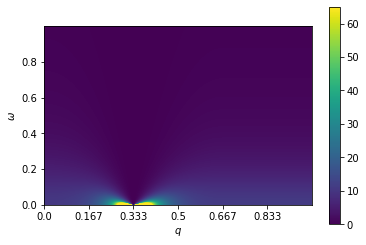

In [126]:
imshow(SSSfw, vmax=65 ,origin='lower')
Npl=np.arange(0,Nomegs,int(Nomegs/5))
Npl2=np.arange(0,len(kpath),int(len(kpath)/6))
om=np.round(np.linspace(0,1,6),3)
t=np.round(np.linspace(0,1,7),3)
colorbar()
plt.xticks(Npl2,t)
plt.yticks(Npl,om)
plt.xlabel(r"$q$")
plt.ylabel(r"$\omega$")

# DISPERISION

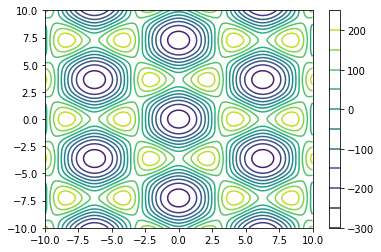

In [128]:
tp1=56.8 #in units of J
tp2=-10.8 #/tpp1
#defining tight bindind dispersion

a_1=a*np.array([1,0])
a_2=a*np.array([1/2,np.sqrt(3)/2])
    
#creating lattice
Np=4
n1=np.arange(-Np,Np+1)
n2=np.arange(-Np,Np+1)
Recip_lat=[]
for i in n1:
    for j in n2:
        point=a_1*i+a_2*j
        Recip_lat.append(point)
    
#getting the nearest neighbours to the gamma point
Recip_lat_arr=np.array(Recip_lat)
dist=np.round(np.sqrt(np.sum(Recip_lat_arr**2, axis=1)),decimals=8)
sorted_dist=sort(list(set(dist)) )
nns=Recip_lat_arr[np.where( (dist<sorted_dist[2]) *( dist>0 ))[0]]
nnns=Recip_lat_arr[np.where( (dist<sorted_dist[3]) *( dist>sorted_dist[1] ))[0]]
def e2d(kx,ky, mu):
    e=0
    for nn in nns:
        e=e-tp1*exp(1j*(nn[0]*kx+nn[1]*ky))
    for nnn in nnns:
        e=e-tp2*exp(1j*(nnn[0]*kx+nnn[1]*ky))
    return np.real(e)-mu

 
#plotting contours
x = np.linspace(-10, 10, 300)
X, Y = np.meshgrid(x, x)
Z = e2d(X, Y, 0)
plt.contour(X, Y, Z,10);
colorbar()